# Lab 11

En este laboratorio cubrimos transformers utilizando texto en el contexto de clasificación. Esta es una version simplificada del original

In [1]:
# Librerías
import keras
from keras import ops
from keras import layers
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Datos y preparación

In [2]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
# Divide val into val and test with sklearn
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
print(len(x_test), "Test sequences")
x_train = keras.utils.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.utils.pad_sequences(x_val, maxlen=maxlen)
x_test = keras.utils.pad_sequences(x_test, maxlen=maxlen)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
25000 Training sequences
12500 Validation sequences
12500 Test sequences


# Arquitectura

1. Bloque transformer

In [ ]:
# Bloque transformer
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim) # Atención multicabeza
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6) # Normalización
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate) # Dropout
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)


2. Embeddings y codificación posicional

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim) # Embedding
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim) # Positional encoding

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

3. Uniendo todo como un clasificador

In [ ]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

# Entrenamiento

In [ ]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(25000, 200) (25000,)
(12500, 200) (12500,)
(12500, 200) (12500,)


In [ ]:
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
history = model.fit(
    x_train, y_train, batch_size=32, epochs=5, validation_data=(x_val, y_val)
)

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 95s 116ms/step - accuracy: 0.7268 - loss: 0.5044 - val_accuracy: 0.8802 - val_loss: 0.2851
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 88s 112ms/step - accuracy: 0.9247 - loss: 0.2016 - val_accuracy: 0.8784 - val_loss: 0.3032
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 141s 111ms/step - accuracy: 0.9652 - loss: 0.1077 - val_accuracy: 0.8489 - val_loss: 0.4356
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 111ms/step - accuracy: 0.9794 - loss: 0.0657 - val_accuracy: 0.8566 - val_loss: 0.4886
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 87s 112ms/step - accuracy: 0.9843 - loss: 0.0495 - val_accuracy: 0.8502 - val_loss: 0.5838


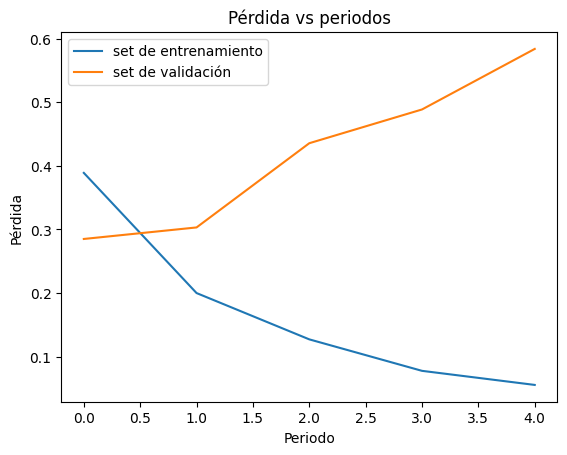

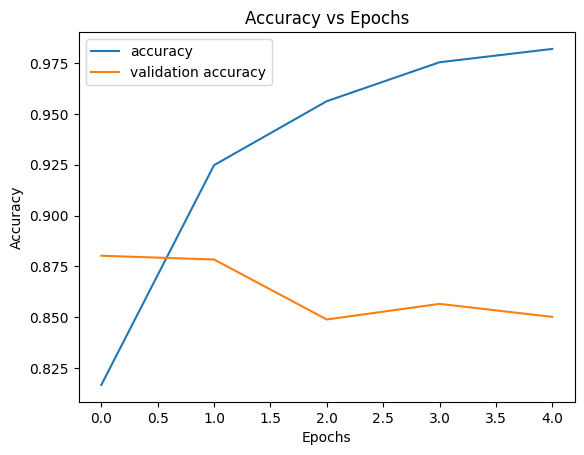

In [ ]:
# Gráficos
plt.plot(history.history["loss"], label="set de entrenamiento")
plt.plot(history.history["val_loss"], label="set de validación")
plt.title("Pérdida vs periodos")
plt.xlabel("Periodo")
plt.ylabel("Pérdida")
plt.legend()
plt.show()

plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="validation accuracy")
plt.title("Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Evaluación

In [ ]:
model.evaluate(x_test, y_test)

391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.8461 - loss: 0.6006


[0.5948633551597595, 0.8483200073242188]

391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step


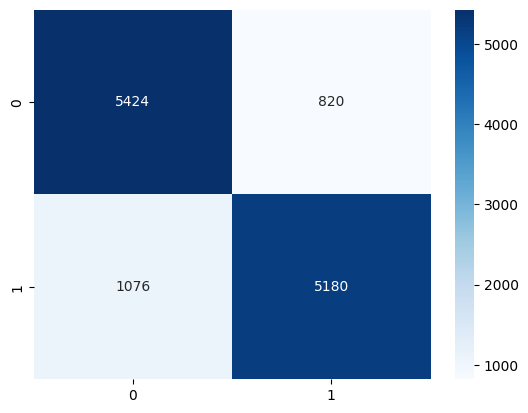

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d",  cmap='Blues')
plt.show()